In [1]:
%reload_ext watermark
%matplotlib inline

import os
import re 
from contextlib import suppress
from metapool.metapool import *
from metapool.util import (join_dfs_from_files, get_set_fp, warn_if_fp_exists, 
                           SET_SUFFIX)
from metapool.mp_strings import (
    PM_BLANK_KEY, MINIPICO_LIB_CONC_KEY, PM_LIB_WELL_KEY, 
    TELLSEQ_BARCODE_ID_KEY)
%watermark -i -v -iv -m -h -p metapool,sample_sheet,openpyxl -u

Last updated: 2024-12-04T17:01:27.137458-08:00

Python implementation: CPython
Python version       : 3.9.19
IPython version      : 8.12.0

metapool    : 0+untagged.221.gd899203
sample_sheet: 0.13.0
openpyxl    : 3.1.4

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 24.1.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Hostname: C02G21EEMD6Q

re        : 2.2.1
json      : 2.0.9
pandas    : 2.2.2
seaborn   : 0.13.2
numpy     : 2.0.0
matplotlib: 3.9.0



In [2]:
! conda list

# packages in environment at /Applications/miniconda3/envs/metapool:
#
# Name                    Version                   Build  Channel
anyio                     4.4.0              pyhd8ed1ab_0    conda-forge
appnope                   0.1.4              pyhd8ed1ab_0    conda-forge
argon2-cffi               23.1.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0           py39hdc70f33_4    conda-forge
arrow                     1.3.0              pyhd8ed1ab_0    conda-forge
asttokens                 2.4.1              pyhd8ed1ab_0    conda-forge
async-lru                 2.0.4              pyhd8ed1ab_0    conda-forge
attrs                     23.2.0             pyh71513ae_0    conda-forge
babel                     2.14.0             pyhd8ed1ab_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
beautifulsoup4            4.12.3             pyha770c72_0    conda-forge
biom-format               2.1.16                   pypi_0  

# Knight Lab TellSeq pipeline notebook D

## Part 5 (of 5): Workflow for Read Distribution Summary and Pool Normalization

### Step 1 of 5: Import plate info for this barcode set

In [3]:
## INPUT
plate_df_set_fp = './test_output/QC/Tellseq_plate_df_C_set_col19to24.txt'

In [4]:
# if the plate_df_set_fp does not end with "C_set_*.txt", throw an error
expected_suffix = rf"C{SET_SUFFIX}_.+\.txt$"

# Check if the file path matches the pattern
if not re.search(expected_suffix, plate_df_set_fp):
    raise ValueError(f"Expected file ending with '{expected_suffix}'")

In [5]:
if not os.path.isfile(plate_df_set_fp):
    print("Problem! %s is not a path to a valid file" % plate_df_set_fp)

In [6]:
plate_df = pd.read_csv(plate_df_set_fp, sep='\t')
plate_df.head()

,Unnamed: 0,index,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,...,i5 well_row,i5 well_col,barcode_set_id,barcode_id,MiniPico Library DNA Concentration,MiniPico Library Concentration,Input DNA,sample sheet Sample_ID,MiniPico Pooled Volume,Well_description
0,288,9,01LJ01593.V8,10,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_2to1dilution,...,A,1,col19to24,C501,0.635,1.924242,7.496689,01LJ01593_V8,1979.166667,Wellcome_Leap_15538_Plate_1_2to1dilution.01LJ0...
1,289,201,01LJ01300.V5,10,Wellcome_Leap_15538_1_2_3_4_10to1dilution,20240911,3,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_3_10to1dilution,...,B,1,col19to24,C509,5.113,15.493939,7.496200,01LJ01300_V5,1979.166667,Wellcome_Leap_15538_Plate_3_10to1dilution.01LJ...
2,290,21,01LJ02603.V8,10,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_2to1dilution,...,C,1,col19to24,C502,0.677,2.051515,7.507742,01LJ02603_V8,1979.166667,Wellcome_Leap_15538_Plate_1_2to1dilution.01LJ0...
3,291,213,01LJ01344.V5,10,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,3,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_3_2to1dilution,...,D,1,col19to24,C510,1.047,3.172727,7.499745,01LJ01344_V5,1979.166667,Wellcome_Leap_15538_Plate_3_2to1dilution.01LJ0...
4,292,33,01LJ04170.V5,10,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_2to1dilution,...,E,1,col19to24,C503,3.777,11.445455,7.495723,01LJ04170_V5,1979.166667,Wellcome_Leap_15538_Plate_1_2to1dilution.01LJ0...


Verify that there are no duplicate barcodes in the selected plate df. This must return True.

In [7]:
## DECISION -- verify no duplicate barcodes
plate_df[TELLSEQ_BARCODE_ID_KEY].value_counts().nunique() == 1

True

In [8]:
# split the evp_plate_df_set_fp to extract the set id
_, set_str = os.path.splitext(plate_df_set_fp)[0].rsplit(SET_SUFFIX, 1)
current_set_id = set_str.replace("_", "").replace(".txt", "")
current_set_id

'col19to24'

In [9]:
row_col_key = f"{PM_LIB_WELL_KEY}_row"
col_col_key = f"{PM_LIB_WELL_KEY}_col"

In [10]:
source_well_names = make_compressed_2d_array(
    plate_df, data_col=PM_LIB_WELL_KEY, 
    row_col=row_col_key, col_col=col_col_key)
source_well_names

array([['A19', 'A20', 'A21', 'A22', 'A23', 'A24'],
       ['B19', 'B20', 'B21', 'B22', 'B23', 'B24'],
       ['C19', 'C20', 'C21', 'C22', 'C23', 'C24'],
       ['D19', 'D20', 'D21', 'D22', 'D23', 'D24'],
       ['E19', 'E20', 'E21', 'E22', 'E23', 'E24'],
       ['F19', 'F20', 'F21', 'F22', 'F23', 'F24'],
       ['G19', 'G20', 'G21', 'G22', 'G23', 'G24'],
       ['H19', 'H20', 'H21', 'H22', 'H23', 'H24'],
       ['I19', 'I20', 'I21', 'I22', 'I23', 'I24'],
       ['J19', 'J20', 'J21', 'J22', 'J23', 'J24'],
       ['K19', 'K20', 'K21', 'K22', 'K23', 'K24'],
       ['L19', 'L20', 'L21', 'L22', 'L23', 'L24'],
       ['M19', 'M20', 'M21', 'M22', 'M23', 'M24'],
       ['N19', 'N20', 'N21', 'N22', 'N23', 'N24'],
       ['O19', 'O20', 'O21', 'O22', 'O23', 'O24'],
       ['P19', 'P20', 'P21', 'P22', 'P23', 'P24']], dtype=object)

### Step 2 of 5: Import and merge per_sample read distributions for this set

Import tsv file(s) with read_counts from per_sample_fastq files and merge with growing plate_df


In [11]:
## INPUT
# Make sure this is for the same barcode set as the plate df file.
# Enter paths to read counts file(s)
read_counts_fps = [
    './test_data/Demux/Tellseq_fastqc_sequence_counts.tsv',
]

In [12]:
# Import reads counts from file to dataframes
CATEGORY_KEY = 'Category'
UNIQUE_READS_KEY = 'Unique Reads'
DUPLICATE_READS_KEY = 'Duplicate Reads'
read_counts_df = join_dfs_from_files(
    read_counts_fps, [CATEGORY_KEY, UNIQUE_READS_KEY, DUPLICATE_READS_KEY],
    unique_cols=[CATEGORY_KEY], 
    dtype={CATEGORY_KEY: str, UNIQUE_READS_KEY: int, DUPLICATE_READS_KEY: int})
    
trimmed_reads_mask = read_counts_df[CATEGORY_KEY].str.contains('trimmed')
raw_read_counts_df = read_counts_df.loc[~trimmed_reads_mask].copy()
filtered_read_counts_df = read_counts_df.loc[trimmed_reads_mask].copy()

##Can also import counts from Qiita per_sample_FASTQ summaries.  
# per_sample_fastq_counts_df = pd.read_csv('./test_data/Demux/YYYY_MM_DD_Celeste_Adaptation_16_17_18_21_per_sample_fastq.tsv',
#                                          sep='\t')

In [13]:
# Merge read_counts_df with plate_df 
plate_df_w_reads = merge_read_counts(
    plate_df, raw_read_counts_df, 
    reads_column_name='Raw Reads')
plate_df_w_reads = merge_read_counts(
    plate_df_w_reads, filtered_read_counts_df, 
    reads_column_name='Filtered Reads')

# plate_df_w_reads = merge_read_counts(
#    plate_df_w_reads, per_sample_fastq_counts_fp,
#    reads_column_name='Qiita Reads')

plate_df_w_reads.head()

,Unnamed: 0,index,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,...,barcode_set_id,barcode_id,MiniPico Library DNA Concentration,MiniPico Library Concentration,Input DNA,sample sheet Sample_ID,MiniPico Pooled Volume,Well_description,Raw Reads,Filtered Reads
0,288,9,01LJ01593.V8,10,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_2to1dilution,...,col19to24,C501,0.635,1.924242,7.496689,01LJ01593_V8,1979.166667,Wellcome_Leap_15538_Plate_1_2to1dilution.01LJ01593.V8.A19,710.0,NaN
1,289,201,01LJ01300.V5,10,Wellcome_Leap_15538_1_2_3_4_10to1dilution,20240911,3,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_3_10to1dilution,...,col19to24,C509,5.113,15.493939,7.496200,01LJ01300_V5,1979.166667,Wellcome_Leap_15538_Plate_3_10to1dilution.01LJ01300.V5.B19,40280.0,1064.0
2,290,21,01LJ02603.V8,10,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_2to1dilution,...,col19to24,C502,0.677,2.051515,7.507742,01LJ02603_V8,1979.166667,Wellcome_Leap_15538_Plate_1_2to1dilution.01LJ02603.V8.C19,1374.0,NaN
3,291,213,01LJ01344.V5,10,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,3,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_3_2to1dilution,...,col19to24,C510,1.047,3.172727,7.499745,01LJ01344_V5,1979.166667,Wellcome_Leap_15538_Plate_3_2to1dilution.01LJ01344.V5.D19,6802.0,378.0
4,292,33,01LJ04170.V5,10,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_2to1dilution,...,col19to24,C503,3.777,11.445455,7.495723,01LJ04170_V5,1979.166667,Wellcome_Leap_15538_Plate_1_2to1dilution.01LJ04170.V5.E19,65646.0,768.0


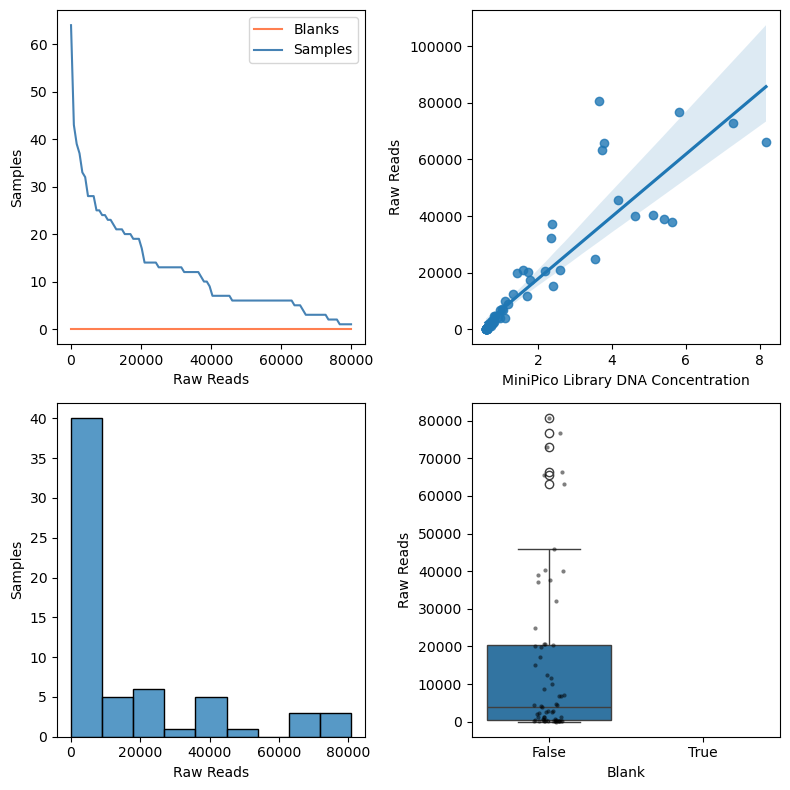

In [14]:
reads_column = 'Raw Reads'

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
# evenness plot
rmax = int(round(plate_df_w_reads[reads_column].max(),-2))
survival_df = pd.concat([read_survival(plate_df_w_reads.loc[plate_df_w_reads[PM_BLANK_KEY] == True,
                                                            reads_column], label='Blanks',rmax=rmax),
                         read_survival(plate_df_w_reads.loc[plate_df_w_reads[PM_BLANK_KEY] == False,
                                                            reads_column], label='Samples',rmax=rmax)])

ax3.set_xlabel(reads_column)
ax3.set_ylabel('Samples')
survival_df.plot(color = ['coral','steelblue'],ax=ax1)
ax1.set_xlabel(reads_column)
ax1.set_ylabel('Samples')

##Histogram
sns.histplot(plate_df_w_reads[reads_column],ax=ax3)

##Regressopm
sns.regplot(x="MiniPico Library DNA Concentration", y=reads_column, data=plate_df_w_reads, ax = ax2)

#Boxplot
sns.boxplot(x=PM_BLANK_KEY, y=reads_column, data=plate_df_w_reads, ax = ax4)
sns.stripplot(x=PM_BLANK_KEY, y=reads_column, data=plate_df_w_reads, ax = ax4,
              size=3,color='black',alpha=0.5)


plt.tight_layout()

### Step 3 of 5: Calculate iSeqnorm pooling volumes

In [15]:
## INPUT
dynamic_range = 5

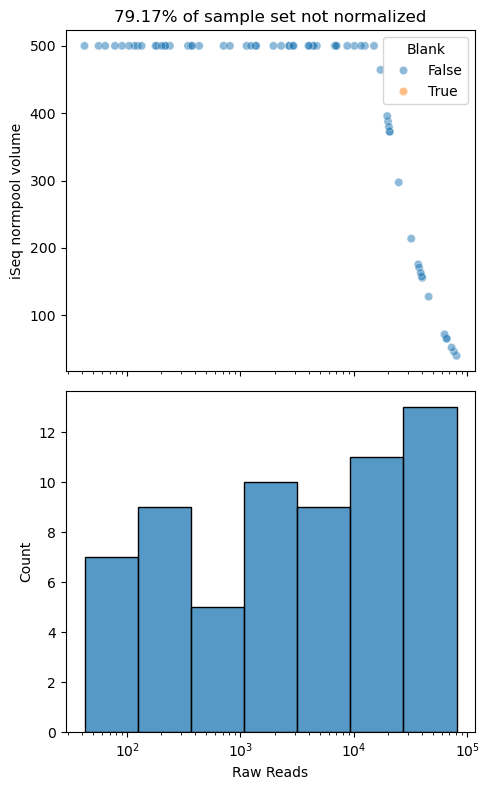

In [16]:
plate_df_normalized = calculate_iseqnorm_pooling_volumes(
    plate_df_w_reads,dynamic_range=dynamic_range, normalization_column='Raw Reads')

In [17]:
ISEQ_NORM_VOL_KEY = 'iSeq normpool volume'

vols = make_compressed_2d_array(
    plate_df_normalized, data_col=ISEQ_NORM_VOL_KEY, 
    row_col=row_col_key, col_col=col_col_key).astype(float)
vols

array([[500.        , 500.        , 100.        , 100.        ,
         65.1612368 ,  52.30061098],
       [155.70233366, 395.75430598, 100.        , 100.        ,
         46.17844196, 163.10315671],
       [500.        , 372.53852822, 100.        , 100.        ,
        157.75949304, 297.36295881],
       [500.        , 500.        , 100.        , 100.        ,
        170.89040008, 500.        ],
       [ 66.55759681, 500.        , 100.        , 100.        ,
        500.        , 372.62475915],
       [500.        , 500.        , 100.        , 100.        ,
        500.        , 500.        ],
       [500.        ,  71.84570652, 100.        , 100.        ,
        500.        , 500.        ],
       [500.        , 213.91586867, 100.        , 100.        ,
        500.        , 500.        ],
       [500.        , 464.33197911, 100.        , 100.        ,
        500.        , 500.        ],
       [500.        ,  40.        , 100.        , 100.        ,
        500.        , 500. 

Pool concentration: 3.29
Pool volume: 29377.07


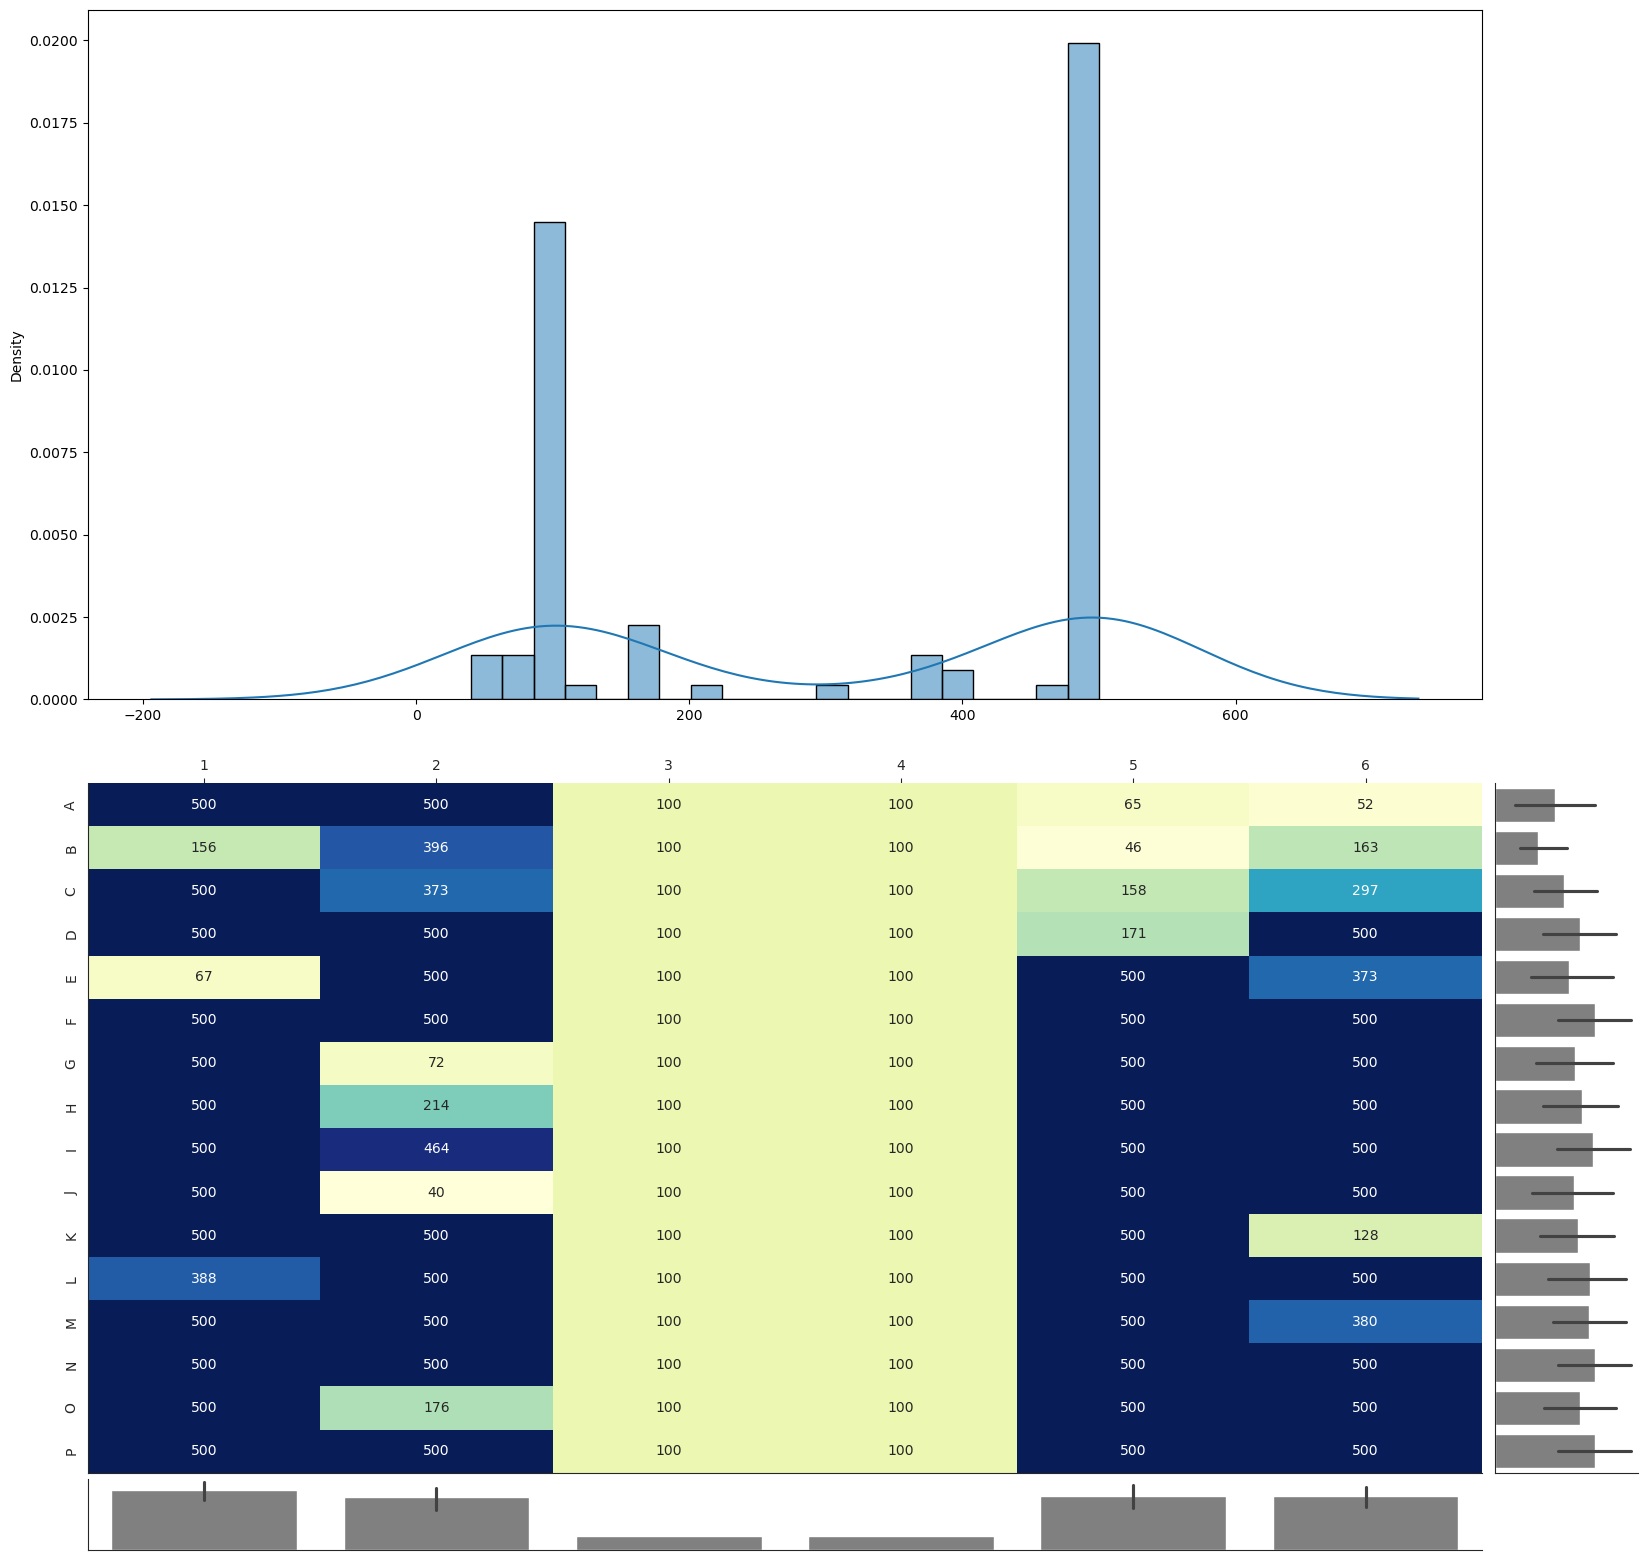

In [18]:
# visualize
conc, vol = estimate_pool_conc_vol(
    plate_df_normalized[ISEQ_NORM_VOL_KEY], 
    plate_df_normalized[MINIPICO_LIB_CONC_KEY])
print("Pool concentration: {:.2f}".format(conc))
print("Pool volume: {:.2f}".format(vol))
with suppress(np.linalg.LinAlgError):
    plot_plate_vals(vols)

### Step 4 of 5: Estimate read depth

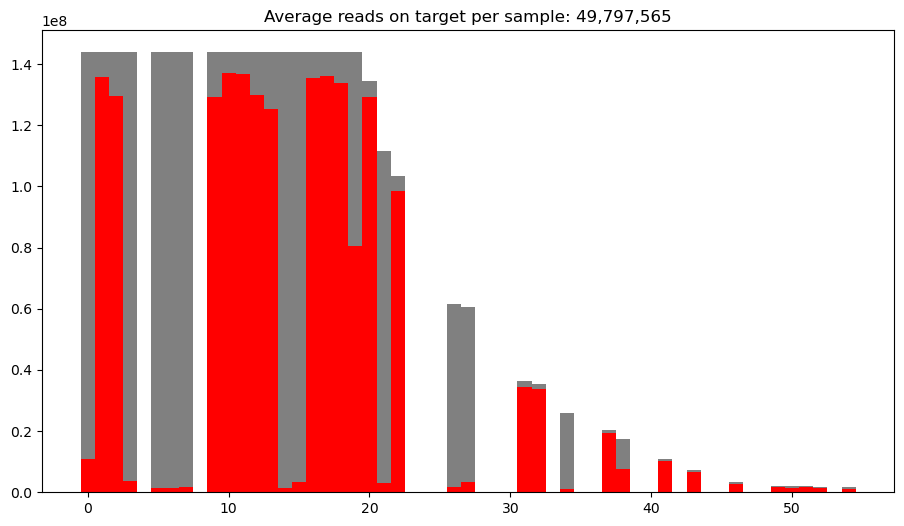

,Unnamed: 0,index,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,...,Filtered Reads,proportion,LoadingFactor,iSeq normpool volume,projected_reads,projected_proportion,projected_HO_reads,on_target_proportion,projected_off_target_reads,projected_on_target_reads
22,310,141,01LJ00544.V5,10,Wellcome_Leap_15538_1_2_3_4_10to1dilution,20240911,2,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_2_10to1dilution,...,4788.0,0.065378,1.276919,71.845707,80806.0,0.035962,1.438482e+08,0.075661,1.329644e+08,1.088374e+07
67,355,215,KATHARO.LEAP.3.12B.120000,12,Wellcome_Leap_15538_1_2_3_4_10to1dilution,20240911,3,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_3_10to1dilution,...,35626.0,0.039044,2.138177,170.890400,80806.0,0.035962,1.438482e+08,0.942686,8.244474e+06,1.356037e+08
80,368,107,KATHARO.LEAP.2.12A.600000,12,Wellcome_Leap_15538_1_2_3_4_10to1dilution,20240911,2,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_2_10to1dilution,...,65794.0,0.075416,1.106962,52.300611,80806.0,0.035962,1.438482e+08,0.901312,1.419604e+07,1.296521e+08
1,289,201,01LJ01300.V5,10,Wellcome_Leap_15538_1_2_3_4_10to1dilution,20240911,3,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_3_10to1dilution,...,1064.0,0.041614,2.006107,155.702334,80806.0,0.035962,1.438482e+08,0.026415,1.400484e+08,3.799763e+06
24,312,153,01LJ00586.V5,10,Wellcome_Leap_15538_1_2_3_4_10to1dilution,20240911,2,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_2_10to1dilution,...,NaN,0.017801,4.689843,464.331979,80806.0,0.035962,1.438482e+08,NaN,NaN,NaN


In [19]:
#Plots estimate of read depth proportion, and returns a df with estimates. 
plate_df_normalized_with_estimates = estimate_read_depth(plate_df_normalized)
plate_df_normalized_with_estimates.head()

### Step 5 of 5: Make pooling picklist and write to a file

In [20]:
## INPUT
iseqnormed_picklist_fbase = './test_output/Pooling/Tellseq_iSeqnormpool'

In [21]:
iseqnormed_picklist = format_pooling_echo_pick_list(
    vols, max_vol_per_well=30000, source_well_names=source_well_names)

In [22]:
iseqnormed_picklist_fp = get_set_fp(iseqnormed_picklist_fbase, current_set_id)
warn_if_fp_exists(iseqnormed_picklist_fp)

/Users/abirmingham/Work/Repositories/fork_metagenomics_pooling_notebook/metapool/util.py:174: UserWarning: Warning! This file exists already: ./test_output/Pooling/Tellseq_iSeqnormpool_set_col19to24.txt.
  warnings.warn(f"Warning! This file exists already: {fp}.")


In [23]:
with open(iseqnormed_picklist_fp,'w') as fh:
    fh.write(iseqnormed_picklist)

!head {iseqnormed_picklist_fp}

Source Plate Name,Source Plate Type,Source Well,Concentration,Transfer Volume,Destination Plate Name,Destination Well
1,384LDV_AQ_B2,A19,,500.00,NormalizedDNA,A1
1,384LDV_AQ_B2,A20,,500.00,NormalizedDNA,A1
1,384LDV_AQ_B2,A21,,100.00,NormalizedDNA,A1
1,384LDV_AQ_B2,A22,,100.00,NormalizedDNA,A1
1,384LDV_AQ_B2,A23,,65.16,NormalizedDNA,A1
1,384LDV_AQ_B2,A24,,52.30,NormalizedDNA,A1
1,384LDV_AQ_B2,B19,,155.70,NormalizedDNA,A1
1,384LDV_AQ_B2,B20,,395.75,NormalizedDNA,A1
1,384LDV_AQ_B2,B21,,100.00,NormalizedDNA,A1
